# Spectral unmixing of fluorescent dyes

Adapted from *Marina Alterman, Yoav Schechner, and Aryeh Weiss, “Multiplexed Fluorescence Unmixing” (2010): 1–8.*


A mixture of $n_{dyes}$ dyes is excited with $S$ different laser line configurations, and the emitted flourescence is measured at $F$ diffrent wavelength bands. For a particular exitation source $s$ and filter band $f$ the corresponding intensity of the image $i_{f,s}$ is given by

$$i_{f,s} = \frac{q_{elect}^{cam}(f)}{g_{gray}^{cam}} \sum_{d=0}^{n_{dyes}} \mathcal{P}\left( N_{d} \left( f,s \right) \right) + \frac{1}{g_{gray}^{cam}} \mathcal{N}\left( 0,\sigma^2_{elect} \right)$$

where

$i_{f,s} \; \left[ \textrm{graylevel} \right]$ gray-scale value of signal in emission filter band $f$ with excitation source $s$.

$g_{gray}^{cam} \; \left[ \textrm{electron} \cdot \textrm{graylevel}^{-1} \right]$ conversion factor from photoelectrons to camera gray-scale values.

$q_{elect}^{cam}(f) \; \left[ \textrm{electron} \cdot \textrm{photon}^{-1} \right]$ quantum efficiency of the detector in filter band $f$ (assumed to be independent of wavelength within a band).

$n_{dyes} \; \left[ \textrm{int} \right]$ number of dyes.

$N_{d} \left( f,s \right) \; \left[ \textrm{photon} \right]$ expected number of photons from dye $d$ in filter band $f$ with exication source $s$. $N_{0} \left( f,s \right)$ is the expected number of background photons.

$\sigma_{elect} \; \left[ \textrm{electron} \right]$ is the standard deviation of the sensor noise.

$\mathcal{P} \left( \lambda \right)$ is a poisson distribution with rate $\lambda$.

$\mathcal{N} \left( \mu, \sigma^2 \right)$ is a normal distribution with mean $\mu$ and variance $\sigma^2$.



For the case where the filter band ranges from $f_{min}$ to $f_{max}$ and there is a single wavelength excitation source $s$, then

$$N_{d} \left( f,s \right) = \left( L(s) \alpha_{d}(s) \int_{f_{min}}^{f_{max}} \tau_{f}^{em}(\lambda) e_d(\lambda) d\lambda \right) N_{d}^{Total}$$

where,  

$N_{d}^{Total} \; \left[ \textrm{int} \right]$ represents the total number of photons that could be collected at the maximum excitation wavelength across the full emission spectrum.

$\alpha_{d}(\lambda) \; \left[ \% \right]$ is the peak normalized absorption of dye $d$ at wavelength $\lambda$, i.e. $\max \left[ \alpha_{d}(\lambda) \right] = 1$.

$e_{d}(\lambda) \; \left[ \% \right]$ is the normalized emission spectrum of dye $d$ at wavelength $\lambda$, i.e. $\int e_{d}(\lambda) d\lambda = 1$.

$\tau_{f}^{em}(\lambda) \; \left[ \% \right]$ is the relative transmissivity of the optics in the emission path for filter $f$ at wavelength $\lambda$.

$L(s) \; \left[ \% \right]$ is the normalized intensity of lightsource $s$.

If multiple excitation laser sources are used simultaneously, the absorption values at those wavelengths can be summed, possibly weighted by the intensity of the light source.

The expected total number of photons from dye is given by

$$ N_{d}^{Total} = \phi_{d} \epsilon_{d} \tau^{em} L t^{exp} V c_{d}$$


where

$c_d \; \left[ \textrm{M} \right]$ is the concentration of dye $d$.

$t^{exp} \; \left[ \textrm{sec} \right]$ is the exposure time.

$V \; \left[ \textrm{cm}^3 \right]$ is the volume of a voxel corresponding to one camera pixel.

$\Phi_{d} \; \left[ \% \right]$ is the quantum yield for emission by an excited dye $d$. It represents emission probability across the entire spectrum.

$\epsilon_{d} \; \left[ \textrm{M}^{-1} \cdot \textrm{cm}^{-1} \right]$ is the molar extinction coefficient of dye $d$. It is the absorption of the dye at the wavelength giving strongest absorption.

$L \; \left[ \textrm{photon} \cdot \textrm{sec}^{-1} \textrm{cm}^{-2} \right]$ is the maxiumum intensity of the light sources.

$\tau^{em} \; \left[ \% \right]$ is the maximum transmissivity of the optics in the emission path.

## setup

In [1]:
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from altair import *

## load spectra

In [4]:
from unmixer import load

In [39]:
data, dyes = load()
dyes = [dyes[d] for d in [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13]]

In [40]:
for d in dyes:
    print d['name']

Alexa Fluor 488
Alexa Fluor 514
Alexa Fluor 532
Alexa Fluor 546
Alexa Fluor 568
Alexa Fluor 594
Alexa Fluor 610
Alexa Fluor 633
Alexa Fluor 647
Alexa Fluor 660
Alexa Fluor 680
Alexa Fluor 700


In [17]:
data['dye'].unique()

array(['Alexa Fluor 488', 'Alexa Fluor 514', 'Alexa Fluor 532',
       'Alexa Fluor 546', 'Alexa Fluor 555', 'Alexa Fluor 568',
       'Alexa Fluor 594', 'Alexa Fluor 610', 'Alexa Fluor 633',
       'Alexa Fluor 635', 'Alexa Fluor 647', 'Alexa Fluor 660',
       'Alexa Fluor 680', 'Alexa Fluor 700', 'DAPI', 'GFP (emerald GFP)'], dtype=object)

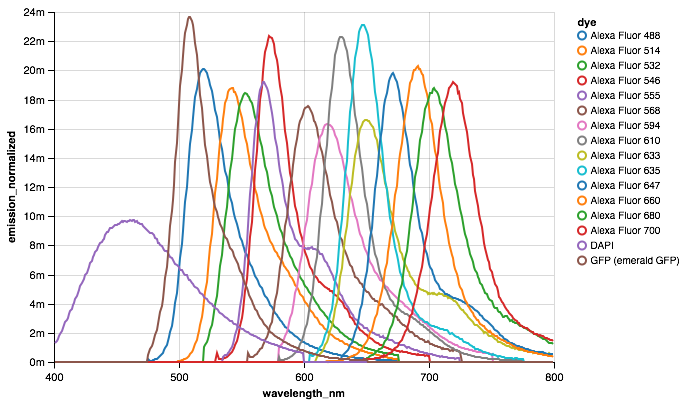

In [18]:
chart = Chart(data
              .query('wavelength_nm > 400 & wavelength_nm < 800')).mark_line().encode(
    x='wavelength_nm',
    y='emission_normalized',
    color='dye'
)
chart.encode(X('wavelength_nm', scale=Scale(domain=[400, 800])))

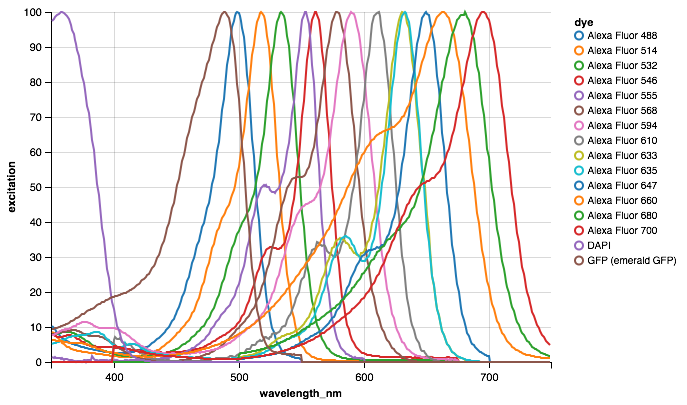

In [19]:
chart = Chart(data.query('wavelength_nm > 350 & wavelength_nm < 750')).mark_line().encode(
    x='wavelength_nm',
    y='excitation',
    color='dye'
)
chart.encode(X('wavelength_nm', scale=Scale(domain=[350, 750])))

## choice of laser lines and filters

In [20]:
from pandas import DataFrame
from numpy import linspace, zeros, ones, concatenate

#laser_lines = [405, 488, 561, 642] #405, 445, 
lines = [488, 515, 561, 594, 642, 685]
#laser_lines = linspace(350, 700, 32).astype(int)

lasers = DataFrame({'wavelength_nm':concatenate((lines, lines)),
                    'laser':concatenate((lines, lines)),
                    'excitation':concatenate((zeros(len(lines)), 100*ones(len(lines))))})

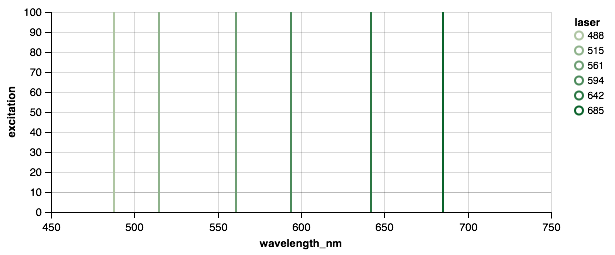

In [21]:
chart = Chart(lasers, height = 200).mark_line().encode(
    x='wavelength_nm',
    y='excitation',
    color='laser:O'
)
chart.encode(X('wavelength_nm', scale=Scale(domain=[450, 750])))

In [22]:
use = ['Alexa Fluor 488', 'Alexa Fluor 514', 'Alexa Fluor 532',
       'Alexa Fluor 546', 'Alexa Fluor 700', 'Alexa Fluor 568',
       'Alexa Fluor 594', 'Alexa Fluor 610', 'Alexa Fluor 633',
       'Alexa Fluor 647', 'Alexa Fluor 660', 'Alexa Fluor 680']

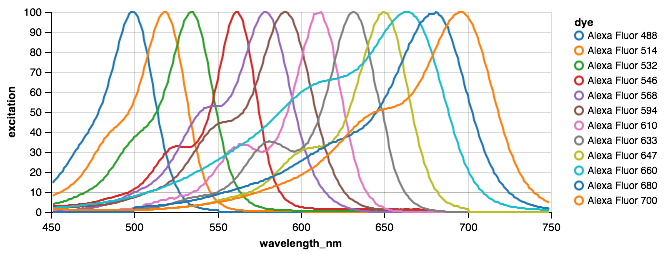

In [23]:
chart = Chart(data
              .query('dye in @use')
              .query('wavelength_nm > 450 & wavelength_nm < 750'),
              height = 200).mark_line().encode(
    x='wavelength_nm',
    y='excitation',
    color='dye'
)
chart.encode(X('wavelength_nm', scale=Scale(domain=[450, 750])))

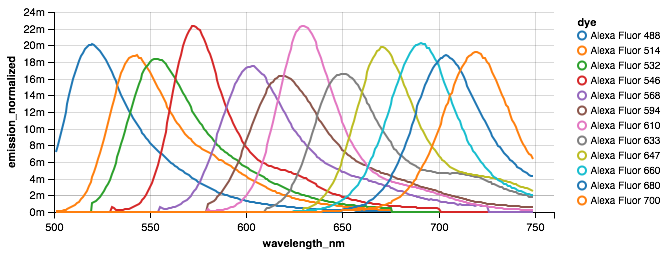

In [24]:
chart = Chart(data
              .query('dye in @use')
              .query('wavelength_nm > 500 & wavelength_nm < 750'),
              height = 200).mark_line().encode(
    x='wavelength_nm',
    y='emission_normalized',
    color='dye'
)
chart.encode(X('wavelength_nm', scale=Scale(domain=[500, 750])))

In [25]:
from numpy import linspace
bands = linspace(450, 750, 32).astype(int)

filters = DataFrame({'wavelength_nm':concatenate((bands, bands)),
                    'filters':concatenate((bands, bands)),
                    'emission':concatenate((zeros(len(bands)), 0.024*ones(len(bands))))})

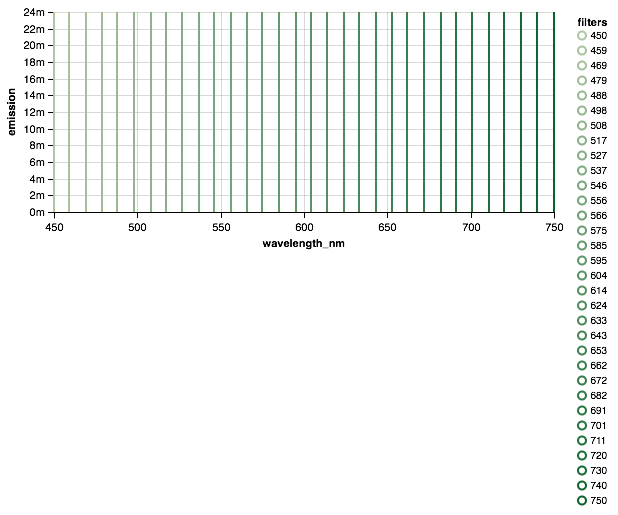

In [26]:
chart = Chart(filters, height = 200).mark_line().encode(
    x='wavelength_nm',
    y='emission',
    color='filters:O'
)
chart.encode(X('wavelength_nm', scale=Scale(domain=[450, 750])))

In [87]:
from unmixer import convert
coeffs_spectra = [convert(lines, bands, d['spectrum'], sum_lasers=False) for d in dyes]

## simulation

In [59]:
results[0]

array([   0.        ,    0.        ,  221.01369579,  180.69747853,
         41.3449073 ,  107.19363211,   98.10455578,  149.61336555,
          0.        ,    0.        ,    0.        ,    5.05101992])

In [60]:
from numpy import asarray

def error_rate(results, count_raw):
    tmp = asarray([(x/x.max()).round() - count_raw for x in results])
    return abs(tmp).any(axis=1).mean()*100

In [43]:
from unmixer import generate, infer, compare, run

In [88]:
# create coefficients and configuration
# could optionally load from JSON files (see test/resources for examples)
coeff = {'emission': [x[1] for x in coeffs_spectra],
         'excitation': [x[0] for x in coeffs_spectra],
         'noise': 1.6, #rms error
         'graylevel' : 37000.0/2**16, #dynamic range 37,000 and 16-bit AD converter
         'qe' : 0.82 #max qe
        }
count_raw = [0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0]
counts = [20000*c + 0 for c in count_raw]

0.0


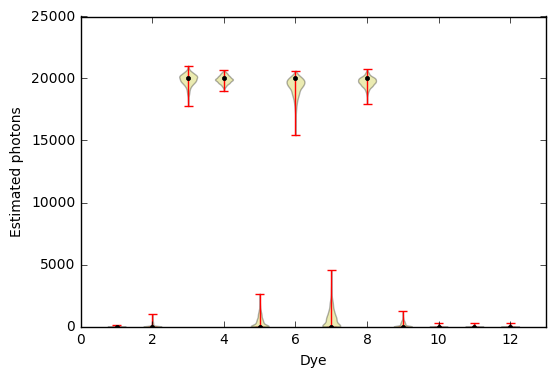

In [69]:
results = run(coeff, counts, 1000, constrained = 'nnls')
plt.violinplot(results);
plt.plot([x+1 for x in range(len(counts))], counts, '.k');
plt.ylabel('Estimated photons');
plt.xlabel('Dye');
plt.xlim([0, 13])
print(error_rate(results, count_raw))

0.0


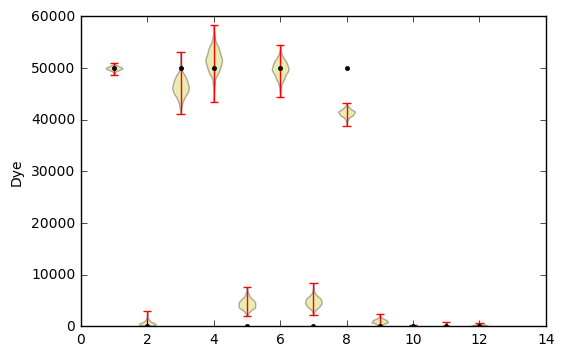

In [93]:
results = run(coeff, counts, 1000, constrained = 'rl')
plt.violinplot(results);
plt.plot([x+1 for x in range(len(counts))], counts, '.k');
plt.ylabel('Estimated photons');
plt.ylabel('Dye');
print(error_rate(results, count_raw))

In [89]:
from numpy import logspace
eF = []
amps = logspace(1, 4, 50)
for amp in amps:
    counts = [amp*c + 0 for c in count_raw]
    results = run(coeff, counts, 5000, constrained = 'nnls')
    eF.append(error_rate(results, count_raw))

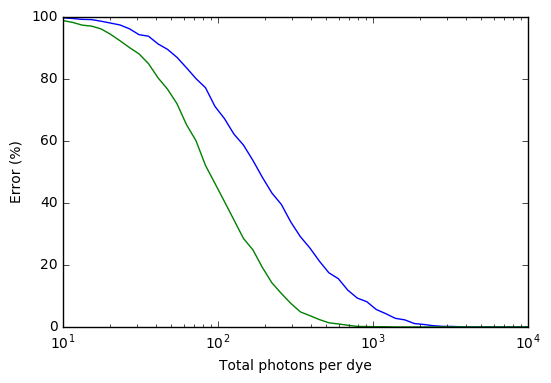

In [90]:
plt.semilogx(amps,e);
plt.semilogx(amps,eF);
plt.xlabel('Total photons per dye');
plt.ylabel('Error (%)');

In [141]:
e = []
amps = linspace(10, 10000, 30)
for amp in amps:
    counts = [amp*c + 0 for c in count_raw]
    results = run(coeff, counts, 1000, constrained = 'lr')
    e.append(error_rate(results, count_raw))

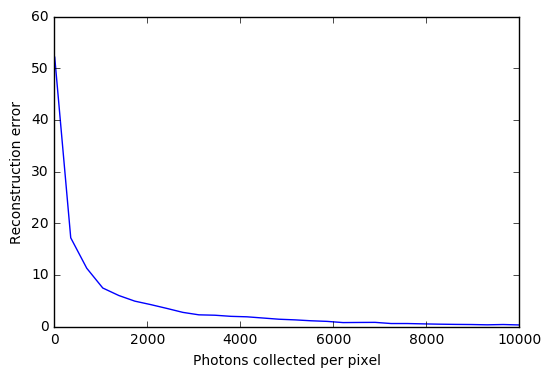

In [142]:
plt.plot(amps,e);
plt.xlabel('Photons collected per pixel');
plt.ylabel('Reconstruction error');

In [139]:
e = []
amps = linspace(10, 10000, 30)
for amp in amps:
    counts = [amp*c + 0 for c in count_raw]
    results = run(coeff, counts, 1000, constrained = 'rl')
    e.append(error_rate(results, count_raw))

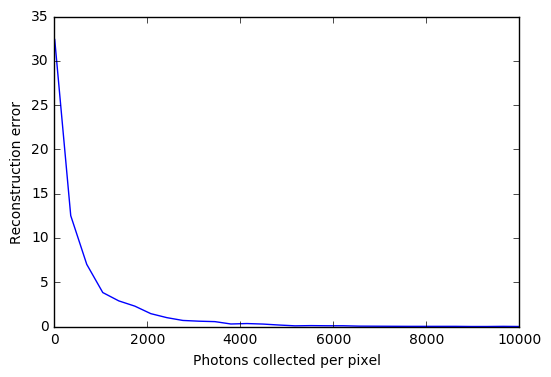

In [140]:
plt.plot(amps,e);
plt.xlabel('Photons collected per pixel');
plt.ylabel('Reconstruction error');

### rl unmix

In [126]:
from unmixer import infer

In [127]:
from numpy import asarray, outer

def setup(signal, coeff):
    emission = asarray(coeff['emission'])
    excitation = asarray(coeff['excitation'])
    tmp = asarray([outer(x, y) for x,y in zip(emission, excitation)])
    y = signal.flatten()*coeff['graylevel']/coeff['qe']
    A = tmp.reshape(tmp.shape[0], tmp.shape[1]*tmp.shape[2]).T
    
    return A, y
    

In [128]:
signal = generate(counts, coeff)

In [129]:
A, y = setup(signal, coeff)

In [130]:
from numpy import ones, dot
def rl(A, y, iterations=100):
    A = A.astype('float')
    An = A/A.sum(axis=0)
    y = y.astype('float')
    
    x = ones(A.shape[1])/A.shape[1]
    for _ in range(iterations):
        c = dot(An, x)
        x *= dot((y+1e-6)/(c+1e-6), An)
    return x*sum(y)/sum(dot(A,x))

In [131]:
x = infer(signal, coeff, method = 'rl')

In [132]:
print(x)

[  2.04396507e+04   1.27873007e+02   1.98233189e+04   1.88037625e+04
   8.81024625e+02   2.12745886e+04   1.48763501e+03   1.62792523e+04
   3.06918524e+02   6.48706522e+00   8.02221122e+01   1.38986531e+02]


In [133]:
x = rl(A, y, iterations=2000)
print(x)

[  2.04396507e+04   1.27873007e+02   1.98233189e+04   1.88037625e+04
   8.81024625e+02   2.12745886e+04   1.48763501e+03   1.62792523e+04
   3.06918524e+02   6.48706522e+00   8.02221122e+01   1.38986531e+02]


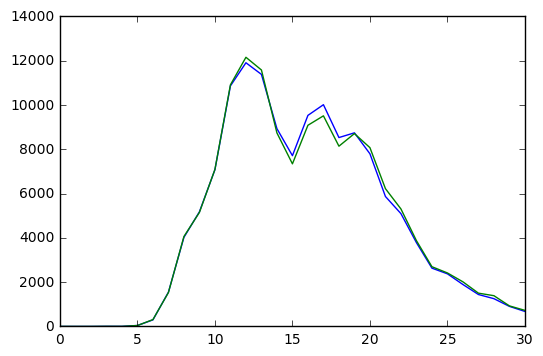

In [134]:
plt.plot(dot(A,x))
plt.plot(y)

In [135]:
from scipy.optimize import nnls
results, rnorm = nnls(A, y)

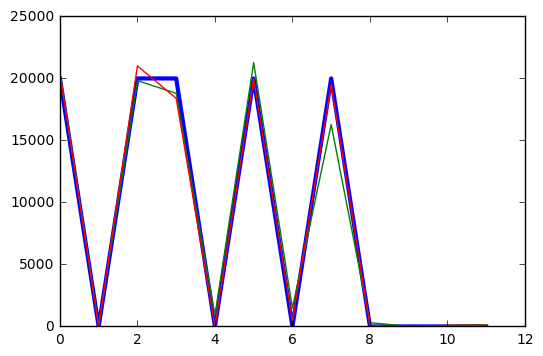

In [136]:
plt.plot(counts,lw=3)
plt.plot(x)
plt.plot(results)


#plt.ylim([-.1, 2000])